## Exercise 1
<!-- @q -->
In this exercise, you will use RandomSearch, GridSearch, and HyperOpt to maximize your performance on ARI.

First, we'll set up some data. Note that all we're doing here is plotting some sine curves in 2D.

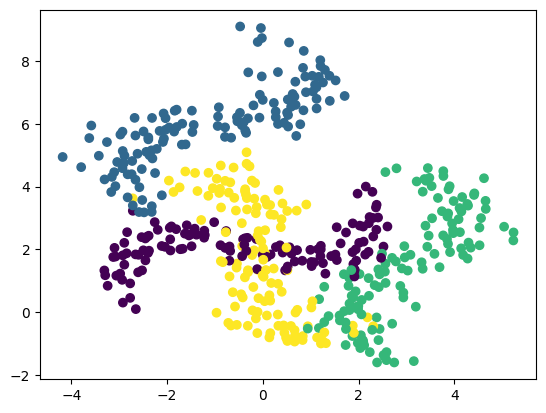

In [19]:
#@SHOW

import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def make_squiggle_clusters(
    n_clusters=3, 
    n_points=500, 
    scaling = 1,
    noise=0.05, 
    rotations=None, 
    seed=42
):
    """
    Generate squiggly clusters by sampling from sine curves, then rotating/translating them.
    
    Parameters
    ----------
    n_clusters : int
        Number of squiggle clusters.
    n_points : int
        Total number of points (split evenly across clusters).
    noise : float
        Standard deviation of Gaussian noise around each squiggle.
    scaling : float
        Applied to scale the size of the sine curves
    rotations : list of floats (optional)
        List of rotation angles in radians for each cluster.
        If None, rotations are drawn randomly.
    seed : int
        Random seed for reproducibility.
        
    Returns
    -------
    X : np.ndarray of shape (n_points, 2)
        Feature coordinates.
    y : np.ndarray of shape (n_points,)
        Ground truth cluster labels.
    """
    rng = np.random.default_rng(seed)
    points_per_cluster = n_points // n_clusters
    t = np.linspace(0, 2*np.pi, points_per_cluster)

    X_list, y_list = [], []

    for i in range(n_clusters):
        # Base squiggle = sine wave
        x = t
        y = scaling * np.sin(t) + rng.normal(0, noise, size=points_per_cluster)

        coords = np.vstack([x, y]).T

        # Apply rotation
        if rotations is None:
            theta = rng.uniform(0, np.pi)
        else:
            theta = rotations[i % len(rotations)]

        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta),  np.cos(theta)]])
        coords = coords @ R.T

        # Translate cluster to avoid total overlap
        offset = rng.uniform(-4, 4, size=2)
        coords += offset

        X_list.append(coords)
        y_list.append(np.full(points_per_cluster, i))

    X = np.vstack(X_list)
    y = np.hstack(y_list)

    return shuffle(X, y, random_state=seed)


X,y = make_squiggle_clusters(n_clusters=4,noise=.5, scaling=1) 
plt.scatter(X[:,0],X[:,1],c=y)   

The following function is a corrected adjusted rand score that effectively penalizes noise points

In [31]:
#@SHOW
from sklearn.metrics import adjusted_rand_score
import numpy as np

def ari_with_singleton_noise(y_true, y_pred, noise_label=-1):
    y_pred = np.asarray(y_pred).copy()
    # assign a unique cluster id to each noise point
    mask = (y_pred == noise_label)
    unique_ids = np.arange(y_pred.max() + 1, y_pred.max() + 1 + mask.sum())
    y_pred[mask] = unique_ids
    return adjusted_rand_score(y_true, y_pred)

And here's a visualization function that will allow you to compare ground truth to your best clustering.

In [ ]:
#@SHOW
def comparison_plot(X,y_pred,y_true,title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # --- True labels ---
    unique_true = np.unique(y_true)
    for label in unique_true:
        mask = y_true == label
        color = "lightgray" if label == -1 else None
        axes[0].scatter(X[mask, 0], X[mask, 1], s=20, label=f"Cluster {label}", c=color)
    axes[0].set_title("Ground Truth")
    axes[0].legend(loc="best", fontsize=8)

    # --- Predicted labels ---
    # @FILL begin
    unique_pred = np.unique(y_pred)
    for label in unique_pred:
        mask = y_pred == label
        color = "lightgray" if label == -1 else None
        axes[1].scatter(X[mask, 0], X[mask, 1], s=20, label=f"Cluster {label}", c=color)
    axes[1].set_title(f"{title}")
    # @FILL end

    plt.tight_layout()
    plt.show()

### Optimize with GridSearchCV


HDBScan does not have a `predict` method, which is used by factory constructed scorers in sklearn.  To accomodate this, we'll define our own scorer.  Also note that since sklearn optimizers are set up for classification problems, rather than clustering, we have to use a manually constructed fold structure for the `cv` parameter.  An example of this is in the lecture notes.

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
from sklearn.cluster import HDBSCAN

# Custom scorer using singletonized ARI - this replaces the default scoring mechanism with a call to `fit_predict` 
# rather than predict
def scorer(estimator, X, y_true):
    labels = estimator.fit_predict(X)
    return ari_with_singleton_noise(y_true, labels)


# Single fold strategy - this is plugged into the `cv` parameter of the optimizer
n = X.shape[0]
one_fold = [(np.arange(n), np.arange(n))]

# TODO: Replace with your code (fill)

print("Best params:", grid.best_params_)
print("Best ARI:", grid.best_score_)

### Visualize your results

Use the `comparison_plot` function to compare your best results to ground truth.

In [ ]:
# Your code here


### Optimize with RandomSearchCV


Now try with `RandomSearchCV`. Because we're operating with sklearn, the same rules apply with respect folds and scorers (you can reuse these objects from above). Additionally, a RandomSearch optimizer allows you search a larger possible space than GridSearchCV but control the number of evaluations.  To make this a fair competition, make sure you use the same total number of trials as you used with the GridSearch.

In [ ]:
# Your code here


### Visualize your results

Once, again, visualize your best results.

In [ ]:
# Your code here


### Optimize with HyperOpt


Hyperopt has a lot more flexibility that either GridSearchCV or RandomSearchCV. Use Hyperopt with an initial random search, as illustrated in the lecture notes.  I've provided some scaffolding code to get you started.

In [ ]:
from hyperopt import fmin, tpe, rand, hp, Trials, STATUS_OK


# Objective function
def objective_hdbscan(params):
    # configure hdbscan and fit it here
    
# TODO: Replace with your code (fill)
    
    labels = clusterer.labels_
    score = ari_with_singleton_noise(y, labels)  # maximize ARI
    return {"loss": 1 - score, "status": STATUS_OK, "score": score}

# TODO: Replace with your code (fill)

# Get best result
best_trial = min(trials.results, key=lambda r: r["loss"])
print("Best score:", best_trial["score"])
print("Best parameters:", trials.best_trial['misc']['vals'])


## Visualize your results


Unfortunately, it's a little hard to extract the best parameters from hyperopt, so you'll probably need to scratch your head a little to figure this out.

In [ ]:
# Your code here


## Exercise 2

<!-- @q -->

The lecture notebook illustrates how you can use an optimizer to cluster texts according to criteria like coverage and coherence.  In the text we used 'fake' data.  Here, we'll use a small set of real data from sklearn's "newsgroups" data set.  The newgroups data is text data that has been harvested from usenet newgroups on several religious topics.  To make this manageable, we'll subsample this data.  Your goal here is to explore the data to get a sense of what sorts of things the different newgroups talk about.  There is no *right* answer here, but as you play with the problem, you will probably find that some results are subjectively better than others.  You might try visualizing things, but chances are good that this will be very hard to interpret.

Try a few parameter settings, and then answer the questions below.

First, gather the data.

In [75]:
#@SHOW
from sklearn.datasets import fetch_20newsgroups

# You can load just a subset of categories for simplicity
categories = ['talk.religion.misc','alt.atheism','soc.religion.christian']

# Load the training data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

# Example of accessing the data
print(newsgroups_train.data[0])
print(newsgroups_train.target[0])  # Corresponding target to the above document

# The size of the dataset can be found by checking the length of the data list
print(f"Training set size: {len(newsgroups_train.data)}")
print("Target distribution")
unique, counts = np.unique(newsgroups_train.target, return_counts=True)
print(np.asarray((unique, counts)).T)

From: jayne@mmalt.guild.org (Jayne Kulikauskas)
Subject: Re: Can sin "block" our prayers?
Organization: Kulikauskas home
Lines: 27

mike@boulder.snsc.unr.edu (Mike McCormick) writes:

> Not honoring our wives can cause our prayers to be hindered:
> 
>         You husbands likewise, live with your wives in
>         an understanding way, as with a weaker vessel,
>         since she is a woman;  and grant her honor as
>         a fellow heir of the grace of life, so that your
>         prayers may not be hindered.  I Peter 3:7

One interpretation I've heard of this verse is that it refers to the sin 
of physically abusing one's wife.  The husband is usually physically 
stronger than his wife but is not permitted to use this to dominate her.  
He must honor her as his sister in Christ.  This would therefore be an 
example of a specific sin that blocks prayer.

This verse also makes me think of the kind of husband who decides what 
is God's will for his family without consulting his wife. 

You'll note the data is a little messy, so here's a little code to clean it up.  You'll need to install nltk with pip to use the follwoing code.

In [77]:
#@SHOW
#Uncomment the following to install nltk
#%pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]1/2 [nltk]
Note: you may need to restart the kernel to use updated packages.


In [79]:
#@SHOW
#You'll also need to install the punkt tokenizer for nltk
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jeintron/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [91]:
#@SHOW


def clean_post(text):
    """Basic cleaning for a single newsgroup post."""
    # 1. Strip metadata header (everything before first blank line)
    if "\n\n" in text:
        text = text.split("\n\n", 1)[1]
    
    # 2. Remove quoted lines (starting with >)
    text = "\n".join([line for line in text.splitlines() if not line.strip().startswith(">")])
    
    # 3. Remove signatures (common marker is '-- ' or '__')
    text = re.split(r'(--\s|__+)', text)[0]
    
    # 4. Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

# Apply cleaning
cleaned_docs = [clean_post(doc) for doc in newsgroups_train.data]

# Sentence tokenize
all_sentences = []
for idx, doc in enumerate(cleaned_docs):
    sentences = nltk.sent_tokenize(doc)
    for sent in sentences:
        all_sentences.append({"sentence": sent, "label": categories[newsgroups_train.target[idx]], "doc_id": idx})

# Build dataframe
df_sentences = pd.DataFrame(all_sentences)

print(df_sentences.head(10))
print("Shape:", df_sentences.shape)

                                            sentence        label  doc_id
0  mike@boulder.snsc.unr.edu (Mike McCormick) wri...  alt.atheism       0
1  The husband is usually physically stronger tha...  alt.atheism       0
2         He must honor her as his sister in Christ.  alt.atheism       0
3  This would therefore be an example of a specif...  alt.atheism       0
4  This verse also makes me think of the kind of ...  alt.atheism       0
5  God reveals His will to both the husband and t...  alt.atheism       0
6  There needs to be some degree of mutuality in ...  alt.atheism       0
7  Even those whose understanding of the Bible le...  alt.atheism       0
8  One way to look at it is that God speaks to th...  alt.atheism       0
9           Jayne Kulikauskas/ jayne@mmalt.guild.org  alt.atheism       0
Shape: (17640, 3)


From here, you can just adapt the code that is in the lecture notebooks.  If you run into memory errors, sample your newsgroup data down to 1000 sentences per newsgroup.  This should still give you a pretty good sample.

In [ ]:
# Your code here


In [ ]:
# Your code here


In [ ]:
# Your code here


In [ ]:
# Your code here


### Set up a helper function to inspect clusters


Create a function that enables you to print out a sample of sentences from a specified cluster.  The function should also print the size and coherence of the cluster.

In [ ]:
import random
import numpy as np

def inspect_cluster(cluster_id, sentences, labels, per_cluster, n_samples=5, seed=42):
    """
    Inspect one cluster: randomly sample N sentences from it.
    
    Parameters
    ----------
    cluster_id : int
        The cluster to inspect.
    sentences : list of str
        Original sentences (aligned with labels).
    labels : array-like
        Cluster labels for each sentence (-1 = noise).
    per_cluster : dict
        Dictionary of coherence scores {cluster_id: score}.
    n_samples : int
        Number of sentences to show.
    seed : int
        Random seed for reproducibility.
    """

# TODO: Replace with your code (fill)

### Inspect multiple clusters


Build a function that uses `inspect_cluster` to print out a sample of sentences for the top N clusters sorted by either size or coherence.

In [ ]:



def sample_clusters(sentences, labels, per_cluster, 
                    rank_by="size", top_m=5, n_samples=3, seed=42):
    """
    Inspect multiple clusters ranked by size or coherence.
    Delegates to inspect_cluster for display.
    
    Parameters
    ----------
    sentences : list of str
        Original sentences (aligned with labels).
    labels : array-like
        Cluster labels for each sentence (-1 = noise).
    per_cluster : dict
        Dictionary of coherence scores {cluster_id: score}.
    rank_by : str, "size" or "coherence"
        How to rank clusters.
    top_m : int
        Number of clusters to inspect.
    n_samples : int
        Number of sentences per cluster.
    seed : int
        Random seed.
    """

# TODO: Replace with your code (fill)

# Inspect top 5 clusters by coherence
sample_clusters(df_sentences["sentence"].tolist(), best_labels, per_cluster, 
                rank_by="size", top_m=5, n_samples=10)

### Compare newsgroups


Build a visualization function that produces bar charts indicating the prevalence (as proportion) of the top N clusters by size (overall) in the three newgroups.  This should allow you to see the different intensities of each topic in the different newsgroups.  After you've done so, use the `inspect_cluster` method above to look at clusters that seem to be very different (or the same!) between newsgroups.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualize_cluster_profiles(top_n, labels, targets):
    """
    Visualize prevalence of top N clusters across newsgroups.
    
    Parameters
    ----------
    top_n : int
        Number of largest clusters to display.
    labels : array-like
        Cluster labels for each sentence (-1 = noise).
    targets : array-like of str
        Ground truth newsgroup name for each sentence (aligned with labels).
    """
# TODO: Replace with your code (fill)

In [ ]:
# Your code here


In [ ]:
# Your code here


### Explore and reflect


Go back now and play with the preceding code to see if you can generate clusterings that make sense, and reveal true differences.  Chances are, you've got some clusters that are filled with useless bits of text that came from the tokenizer.  Can you modify the tokenizer to improve this at all? You can also fiddle with how you've parameterized your loss function, or even modify it. For instance, you might have lots of tiny clusters, but perhaps you want larger, more robust clusters?

Once you're satisfied, try to build an understanding of the differences between the newsgroups.  Do the clusters you've found make sense, given your understanding of the topics being discussed here?  You might need to google a little to figure out what some of these topics are about!

Once you're done, answer the following:

1. What modifications did you try and why?  What seemed to work?  What didn't?
2. How do you decide if a cluster is "good" or not.  Do you think coherence does a good job?  Can you think of anything that better captures your intuitions?
3. What are the clearest differences you can find between the three newsgroups? Tell me if this makes sense given your understanding of the topic areas.

*Enter your answer in this cell*